In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from tqdm import tqdm_notebook
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import layers

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean.set'))
eeg_present = len(eegs) > 0
all_present = mep_present and eeg_present
print(all_present)

True


In [3]:
eegs = [
    'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub10/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub11/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean.set'
]

In [4]:
# Read EEG file and prepare epochs in dataframes.
def read_eeg(path):
    epochs = read_epochs_eeglab(path)
    epochs = epochs.pick_channels(ch_names=['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'])
    epoch_list = []
    i = 0
    for epoch in epochs.iter_evoked():
        df = epoch.to_data_frame()
        epoch_list.append(df)
    return epoch_list

In [5]:
# Select EEG before TMS.
def crop_epochs(epoch_list, duration_millis=500, sampling_rate=1000):
    new_epoch_list = []
    for epoch_df in epoch_list:
        # Delete EEG after TMS event.
        epoch_df['signal time'] = epoch_df.index
        epoch_df = epoch_df.reset_index()
        indices = epoch_df.index[epoch_df['signal time'] == 0].tolist()
        event_index = int(len(indices)/2)
        delete_count = epoch_df.shape[0] - indices[event_index]
        epoch_df = epoch_df.drop(epoch_df.tail(delete_count).index)

        # Select EEG for the selected duration.
        keep = int(duration_millis * sampling_rate / 1000)
        delete_count = epoch_df.shape[0] - keep
        epoch_df = epoch_df.drop(epoch_df.head(delete_count).index)

        # Append the epoch in the list.
        epoch_df = epoch_df.set_index('signal time')
        new_epoch_list.append(epoch_df)
    return new_epoch_list, -keep

In [6]:
# Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

In [7]:
# Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

In [8]:
# Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

In [9]:
# Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

In [10]:
# Calculate EEG area.
def calculate_eeg_area(epoch_df):
    gfp = np.sum(epoch_df ** 2, axis=1)
    times = gfp.index
    gfp = mne.baseline.rescale(gfp.values, times, baseline=(None, 0))
    return np.trapz(gfp, times)

In [11]:
# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 1000
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

In [12]:
def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

In [13]:
def filter_electrodes(epoch, which='lm1'):
    if which == 'ltm1':
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC2',
                'FC6', 'M1', 'T7', 'Cz', 'C4', 'T8', 'M2', 'CP2',
                'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FCz', 'FC4',
                'C2', 'C6', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)
    else:
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1',
                'M1', 'T7', 'C3', 'Cz', 'T8', 'M2', 'CP5', 'CP1',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'C5',
                'C1', 'CP3', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)

In [14]:
def band_max(freq, psd, start=0, end=4):
    start = np.where(freq==start)
    if len(start) > 0:
        start = start[0][0]
    else:
        start = 0
    end = np.where(freq==end)
    if len(end) > 0:
        end = end[0][0]
    else:
        end = start + 4
    freq = freq[start:end]
    psd = psd[start:end]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

In [15]:
def extract_features(eeg_path, mep_path):
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_epochs(epochs)
    mep_frames = open_mep_as_df(mep_path)
    if len(epochs) != len(mep_frames):
        raise Exception('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path)
        return
    epoch_features = []
    for i in range(len(epochs)):
        epoch = epochs[i]
        mep = mep_frames[i]
        segments = eeg_path.split('/')
        d = {'sub': segments[2], 'exp': segments[3], 'run': segments[5], 'epoch': i}

        freq, psd = calculate_eeg_frequency(epoch.drop('time', axis=1).values.mean(axis=1))
        d['all_all_max_power_freq'], d['all_all_max_power'] = band_max(freq, psd, 4, 40)
        d['all_delta_max_power_freq'], d['all_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['all_theta_max_power_freq'], d['all_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['all_alpha_max_power_freq'], d['all_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['all_beta_max_power_freq'], d['all_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['all_gamma_max_power_freq'], d['all_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'ltm1').values.mean(axis=1))
        d['ltm1_all_max_power_freq'], d['ltm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['ltm1_delta_max_power_freq'], d['ltm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['ltm1_theta_max_power_freq'], d['ltm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['ltm1_alpha_max_power_freq'], d['ltm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['ltm1_beta_max_power_freq'], d['ltm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['ltm1_gamma_max_power_freq'], d['ltm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'rtm1').values.mean(axis=1))
        d['rtm1_all_max_power_freq'], d['rtm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['rtm1_delta_max_power_freq'], d['rtm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['rtm1_theta_max_power_freq'], d['rtm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['rtm1_alpha_max_power_freq'], d['rtm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['rtm1_beta_max_power_freq'], d['rtm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['rtm1_gamma_max_power_freq'], d['rtm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        d['area_under_eeg'] = calculate_eeg_area(epoch.drop('time', axis=1))
        d['rtm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch.drop('time', axis=1), 'rtm1'))
        d['ltm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch.drop('time', axis=1), 'ltm1'))
        d['all_max_amplitude'] = calculate_eeg_max_amplitude(epoch.drop('time', axis=1))
        d['rtm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch.drop('time', axis=1), 'rtm1'))
        d['ltm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch.drop('time', axis=1), 'ltm1'))

        d['mep_size'] = calculate_mep_size(mep)
        epoch_features.append(d)
    return epoch_features

In [16]:
features = []
eegs_to_ignore = ['data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set', 
                  'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set']
for eeg_path in tqdm_notebook(eegs):
    if (eeg_path in eegs_to_ignore):
        continue
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    features = features + extract_features(eeg_path, mep_path)

Extracting parameters from data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baselin

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub08/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baselin

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub10/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub11/exp01/eeg/SP 110RMT/clean.set

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub13/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)



/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

In [18]:
df = pd.DataFrame(features)
df.head()

,all_all_max_power,all_all_max_power_freq,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,all_gamma_max_power,all_gamma_max_power_freq,...,rtm1_beta_max_power_freq,rtm1_delta_max_power,rtm1_delta_max_power_freq,rtm1_gamma_max_power,rtm1_gamma_max_power_freq,rtm1_max_amplitude,rtm1_theta_max_power,rtm1_theta_max_power_freq,run,sub
0,1.989766,4.0,0.870753,8.0,0.473992,18.0,0.675670,2.0,0.793374,100.0,...,22.0,2.622572,2.0,0.350047,32.0,30.874209,2.459739,4.0,SP 110RMT r1,sub03
1,4.196050,4.0,0.264906,8.0,1.787478,20.0,1.918994,2.0,0.735555,100.0,...,22.0,3.543211,2.0,1.263396,46.0,21.239529,5.355808,6.0,SP 110RMT r1,sub03
2,1.465408,4.0,0.453807,10.0,0.812771,16.0,2.463688,2.0,1.089828,38.0,...,26.0,3.092446,2.0,0.565638,68.0,28.091112,0.732845,4.0,SP 110RMT r1,sub03
3,5.145828,4.0,3.098915,8.0,3.054354,16.0,4.033659,2.0,0.752304,100.0,...,16.0,7.459945,2.0,1.056526,36.0,25.804140,6.276831,4.0,SP 110RMT r1,sub03
4,3.617220,4.0,1.177311,14.0,1.422066,18.0,5.411717,2.0,0.696179,100.0,...,16.0,0.624138,2.0,1.694291,32.0,20.615904,0.990355,4.0,SP 110RMT r1,sub03


# Input pipeline

In [35]:
x = df.copy()
y = df['mep_size']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

In [61]:
def prepare_data(rows):
    last_sub = ''
    last_exp = ''
    last_run = ''
    last_eeg = ''
    for _, row in rows.iterrows():
        if last_sub != row['sub'] or last_exp != row['exp'] or last_run != row['run']:
            epochs = read_eeg('data/original/'+row['sub']+'/'+row['exp']+'/eeg/'+row['run']+'/clean.set')
            epochs, _ = crop_epochs(epochs)
            last_sub = row['sub']
            last_exp = row['exp']
            last_run = row['run']
            last_eeg = epochs
        filename = 'wavelets/' + last_sub + '-' + last_exp + '-' + last_run + '-' + str(row['epoch']) + '-all' + '.png'
        all_wavelet = mpimg.imread(filename)
        filename = 'wavelets/' + last_sub + '-' + last_exp + '-' + last_run + '-' + str(row['epoch']) + '-rtm1' + '.png'
        rtm1_wavelet = mpimg.imread(filename)
        filename = 'wavelets/' + last_sub + '-' + last_exp + '-' + last_run + '-' + str(row['epoch']) + '-ltm1' + '.png'
        ltm1_wavelet = mpimg.imread(filename)
        features = row[['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
           'all_alpha_max_power_freq', 'all_beta_max_power',
           'all_beta_max_power_freq', 'all_delta_max_power',
           'all_delta_max_power_freq', 'all_gamma_max_power',
           'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
           'all_theta_max_power_freq', 'area_under_eeg',
           'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
           'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
           'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
           'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
           'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
           'ltm1_max_amplitude', 'ltm1_theta_max_power',
           'ltm1_theta_max_power_freq', 'rtm1_all_max_power',
           'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
           'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
           'rtm1_beta_max_power', 'rtm1_beta_max_power_freq',
           'rtm1_delta_max_power', 'rtm1_delta_max_power_freq',
           'rtm1_gamma_max_power', 'rtm1_gamma_max_power_freq',
           'rtm1_max_amplitude', 'rtm1_theta_max_power',
           'rtm1_theta_max_power_freq']]
        yield [last_eeg, all_wavelet, rtm1_wavelet, ltm1_wavelet, features], row['mep_size']

In [62]:
x = prepare_data(x_train)
y = next(x)

Extracting parameters from data/original/sub10/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int

5

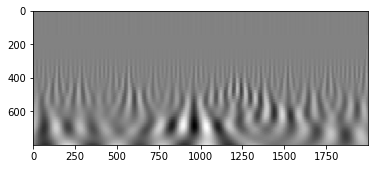

In [60]:
plt.imshow(y[1])

In [ ]:
tf.debugging.set_log_device_placement(True)
dataset_train = tf.data.Dataset.from_generator(lambda: prepare_data(x_train), (tf.float64, tf.float64), (tf.TensorShape([10, 64, 8193, 1]), tf.TensorShape([1, 64, 2000, 1])))
dataset_test = tf.data.Dataset.from_generator(lambda: prepare_data(x_test), (tf.float64, tf.float64), (tf.TensorShape([10, 64, 8193, 1]), tf.TensorShape([1, 64, 2000, 1])))